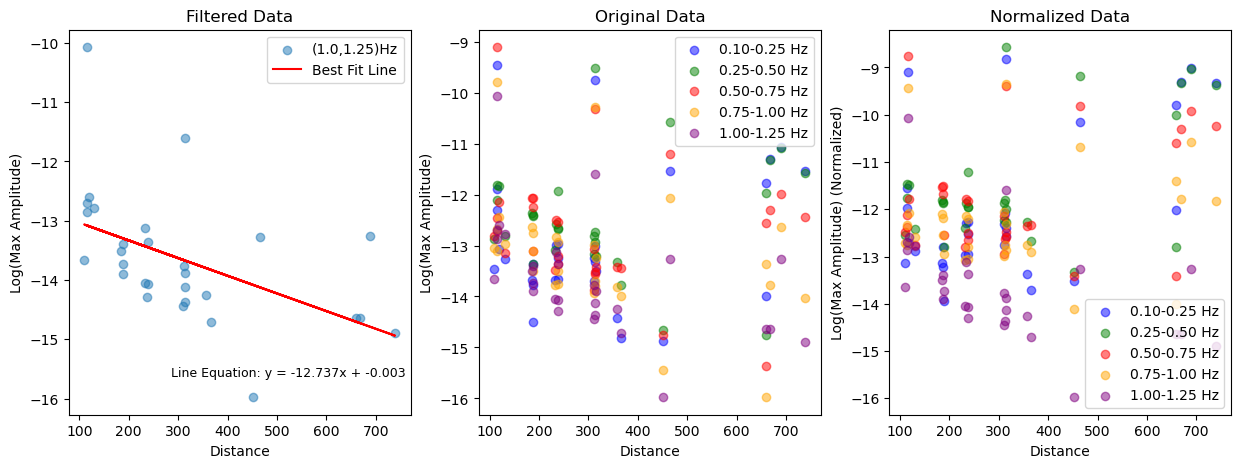

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pickle  # Import the pickle module

def bestfit():

    # Load the original DataFrame from the pickle file
    with open('AllResults.pkl', 'rb') as pkl_file:
        original_dataframe = pickle.load(pkl_file)

    # Calculate Z-scores for log-transformed max amplitude data
    z_scores = np.abs(stats.zscore(np.log(original_dataframe['max amplitude'])))

    # Set a threshold for outlier detection (e.g., Z-score greater than 3)
    threshold = 3

    # Remove outliers based on the threshold
    outlier_removed_df = original_dataframe[(z_scores < threshold)]

    # Filter only the frequency band (1.0, 1.25) as a reference
    filtered_dataframe = outlier_removed_df[outlier_removed_df['frequency band'] == (1.0, 1.25)]

    # Calculate the best fit line for the log-transformed filtered data
    filtered_distance = filtered_dataframe['distance']
    filtered_log_max_amplitude = np.log(filtered_dataframe['max amplitude'])
    filtered_coefficients = np.polyfit(filtered_distance, filtered_log_max_amplitude, 1)
    filtered_best_fit_line = np.poly1d(filtered_coefficients)
    filtered_slope = filtered_coefficients[0] 

    # Create a new DataFrame for the normalized data
    normalized_dataframe = original_dataframe.copy()
    
    return outlier_removed_df, filtered_distance, filtered_best_fit_line, filtered_slope

def normalize_max_amplitude(row, filtered_best_fit_line, filtered_slope):
    if row['frequency band'] != (1.0, 1.25):
        return np.exp(np.log(row['max amplitude']) - filtered_slope * row['distance'])
    else:
        return row['max amplitude']

def normalization(outlier_removed_df, filtered_distance, filtered_best_fit_line, filtered_slope):
    
    # Create a new DataFrame for the normalized data
    normalized_dataframe = outlier_removed_df.copy()

    # Apply the normalization function to create the 'max amplitude (normalized)' column
    normalized_dataframe['max amplitude (normalized)'] = normalized_dataframe.apply(lambda row: normalize_max_amplitude(row, filtered_best_fit_line, filtered_slope), axis=1)

    # Save the normalized DataFrame to a pkl file
    normalized_dataframe.to_pickle('normalized.pkl')

    # Plot the log-transformed original data
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Subplot 1: Filtered data with best fit line
    axs[0].scatter(filtered_distance, np.log(filtered_dataframe['max amplitude']), marker='o', label='(1.0,1.25)Hz', alpha=0.5)
    axs[0].plot(filtered_distance, filtered_best_fit_line(filtered_distance), color='red', label='Best Fit Line')
    axs[0].set_title('Filtered Data')
    axs[0].set_xlabel('Distance')
    axs[0].set_ylabel('Log(Max Amplitude)')
    
    # Add equation of the line as a text annotation (adjust position)
    equation = f'Line Equation: y = {filtered_best_fit_line[0]:.3f}x + {filtered_best_fit_line[1]:.3f}'
    axs[0].text(0.30, 0.10, equation, transform=axs[0].transAxes, fontsize=9)  # Adjust position here

    axs[0].legend()

    # Subplot 2: Original data with different colors for each frequency band (excluding 1.0,1.25 Hz)
    color_mapping = {
        (0.10, 0.25): 'blue',
        (0.25, 0.50): 'green',
        (0.50, 0.75): 'red',
        (0.75, 1.00): 'orange',
        (1.00, 1.25): 'purple',
    }
    for freq_range, group in normalized_dataframe.groupby('frequency band'):
        color = color_mapping[tuple(freq_range)]
        axs[1].scatter(group['distance'], np.log(group['max amplitude']), marker='o', alpha=0.5, label=f'{freq_range[0]:.2f}-{freq_range[1]:.2f} Hz', color=color)
    axs[1].set_title('Original Data')
    axs[1].set_xlabel('Distance')
    axs[1].set_ylabel('Log(Max Amplitude)')
    axs[1].legend()

    # Subplot 3: Normalized data with different colors for each frequency band (including 1.0,1.25 Hz)
    for freq_range, group in normalized_dataframe.groupby('frequency band'):
        color = color_mapping[tuple(freq_range)]
        axs[2].scatter(group['distance'], np.log(group['max amplitude (normalized)']), marker='o', alpha=0.5, label=f'{freq_range[0]:.2f}-{freq_range[1]:.2f} Hz', color=color)
    axs[2].set_title('Normalized Data')
    axs[2].set_xlabel('Distance')
    axs[2].set_ylabel('Log(Max Amplitude) (Normalized)')
    axs[2].legend()

    plt.show()
    
    return normalized_dataframe

# call functions
outlier_removed_df, filtered_distance, best_fit, slope = bestfit()
normalized_dataframe = normalization(outlier_removed_df, filtered_distance, best_fit, slope)

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.interpolate import interp1d

# def interp():
    
#     # Load the original DataFrame from the pickle file
#     with open('AllResults.pkl', 'rb') as pkl_file:
#         original_dataframe = pickle.load(pkl_file)

#     # Filter the original DataFrame for the target frequency band (1.0, 1.25)
#     filtered_dataframe = original_dataframe[original_dataframe['frequency band'] == (1.0, 1.25)]

#     # Set up a figure with two subplots side by side
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#     # Plot max amplitudes against distance in the left subplot (filtered data)
#     for freq_range, group in filtered_dataframe.groupby('frequency band'):
#         ax1.scatter(group['distance'], group['max amplitude'], label=f'{freq_range[0]:.2f}-{freq_range[1]:.2f} Hz', marker='o')

#     # Add labels and legend to the left subplot
#     ax1.set_title('Max Amplitude vs. Distance (Filtered Data)')
#     ax1.set_xlabel('Distance (km)')
#     ax1.set_ylabel('Max Amplitude')
#     ax1.set_yscale('log')
#     ax1.legend()

#     # In the right subplot, plot filtered max amplitudes with an interpolation line
#     for freq_range, group in filtered_dataframe.groupby('frequency band'):
#         ax2.scatter(group['distance'], group['max amplitude'], label=f'{freq_range[0]:.2f}-{freq_range[1]:.2f} Hz (Filtered Data)', marker='o')
#         interpolation_function = interp1d(group['distance'], group['max amplitude'], kind='cubic')
#         interpolated_distances = group['distance'].values
#         interpolated_max_amplitudes = interpolation_function(interpolated_distances)
#         ax2.plot(interpolated_distances, interpolated_max_amplitudes, label=f'{freq_range[0]:.2f}-{freq_range[1]:.2f} Hz (Interpolation)')

#     # Add labels and legend to the right subplot
#     ax2.set_title('Max Amplitude vs. Distance (Filtered Data with Interpolation)')
#     ax2.set_xlabel('Distance (km)')
#     ax2.set_ylabel('Max Amplitude')
#     ax2.set_yscale('log')
#     ax2.legend()

#     plt.tight_layout()
#     plt.show()

# interp()